In [6]:
from datetime import datetime
import matplotlib.pyplot as plt
import task_01
import importlib
importlib.reload(task_01)
from task_01 import total_filtered_data

#Global Variables
data_path = 'data/PhysicalFlows_12.1.G'
file_matter = 'PhysicalFlows_12.1.G.csv'
nordlink_opening = datetime(2020, 12, 9)

#Total Data for Physical Flows
data = total_filtered_data(data_path, file_matter)
physical_data = data['physical_data']
period = 'year'
purpose = 'overview'

In [4]:
import pandas as pd

def physical_flow(dataframe, period='year', purpose='overview', first_year=2019, last_year=2023):
    # Filter Years
    dataframe = dataframe[(dataframe['DateTime'].dt.year >= first_year) & 
                          (dataframe['DateTime'].dt.year <= last_year)]
    
    #Mark Exports or Imports
    dataframe['FlowType'] = dataframe.apply(
        lambda row: 'export' if row['OutMapCode'] == 'NO2' and row['InMapCode'] == 'DE_LU' else
                    'import' if row['OutMapCode'] == 'DE_LU' and row['InMapCode'] == 'NO2' else None, axis=1)
    
    #Drop Irrelevant Data
    dataframe = dataframe[dataframe['FlowType'].notna()]

    #Exports are Positive, Imports are Negative, Aids Net Calculation
    dataframe['FlowValue'] = dataframe.apply(lambda x: x['FlowValue'] if x['FlowType'] == 'export' else -x['FlowValue'], axis=1)

    #Handle Different Operations
    if purpose == 'overview' and period == 'year':
        annual_imports = dataframe[dataframe['FlowType'] == 'import'].groupby(dataframe['DateTime'].dt.year)['FlowValue'].sum().abs()
        annual_exports = dataframe[dataframe['FlowType'] == 'export'].groupby(dataframe['DateTime'].dt.year)['FlowValue'].sum()
        overview_data = pd.DataFrame({'imports': annual_imports, 'exports': annual_exports})
        return overview_data

    elif purpose == 'net' and period == 'week':
        # Weekly net exports: exports - imports
        weekly_net = dataframe.resample('W', on='DateTime')['FlowValue'].sum()
        weekly_net_df = weekly_net.reset_index()
        weekly_net_df.columns = ['Date', 'Net Export']
        return weekly_net_df

    else:
        raise ValueError("Invalid combination of period and purpose. Use 'year' for period with 'overview' or 'week' for period with 'net'.")


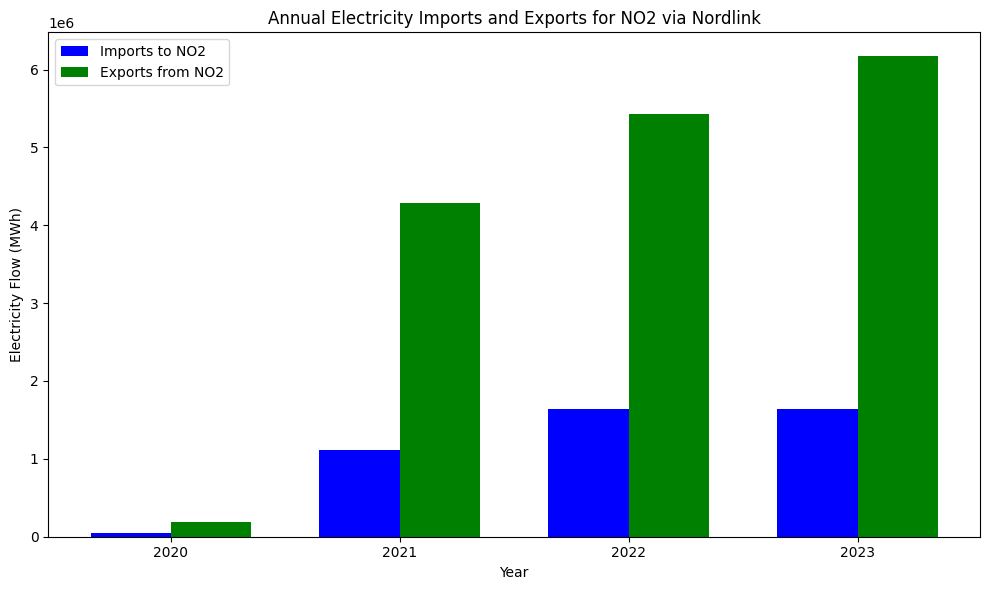

In [7]:
annual_flow_no2 = physical_flow(physical_data, period, purpose)

#Prepare Variables for Visualization
years = annual_flow_no2.index.tolist()
import_values = annual_flow_no2['imports'].tolist()
export_values = annual_flow_no2['exports'].tolist()

#Plotting
fig, ax = plt.subplots(figsize=(10, 6))

#Creating Bar Width and Position
bar_width = 0.35
r1 = range(len(years))
r2 = [x + bar_width for x in r1]

#Bar Plot Imports and Exports
ax.bar(r1, import_values, color='blue', width=bar_width, label='Imports to NO2')
ax.bar(r2, export_values, color='green', width=bar_width, label='Exports from NO2')

#Adding Labels and Titles
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Flow (MWh)')
ax.set_title('Annual Electricity Imports and Exports for NO2 via Nordlink')
ax.set_xticks([r + bar_width / 2 for r in range(len(years))])
ax.set_xticklabels(years)
ax.legend()

#Saving Figure
plt.tight_layout()
plt.savefig('figure_task3.png')
plt.show()